In [ ]:
import os
import re
import unicodedata
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModel
from pythainlp.tokenize import word_tokenize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce  

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp


Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}

In [ ]:
# =========================
# Load & clean data
# =========================
df = pd.read_csv('news_dataset_truefakenews.csv')



In [ ]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'ข่าวปลอม': 'fake',  
}

In [ ]:
# ทำความสะอาด label ลบอิโมจิ และแมปค่า 
# Normalization Function

#ลบ

# Remove zero-width characters  
ZW = ''.join(['\u200B', '\u200C', '\u200D', '\uFEFF'])


def normalize_thai(s):
    if pd.isna(s):
        return None
    #non-breaking space
    s = str(s).replace('\u00A0', ' ').translate({ord(ch): None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # collapse repeated diacritics/marks
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['label'] = df['label'].apply(normalize_thai) #print



#Map Label ให้เป็นคลาสที่ถูกต้อง
CANON = {'ข่าวจริง': 'ข่าวจริง', 'ข่าวปลอม': 'ข่าวปลอม'}
ALIASES = {'ข่าวจริิง': 'ข่าวจริง', 'ข่่าวจริง': 'ข่าวจริง', 'ข่่าวบิดเบือน': 'ข่าวปลอม'}

# แทนที่ label ที่เป็น alias ให้เป็น canonical form
df['label'] = df['label'].replace(ALIASES)
df = df[df['label'].isin(CANON.keys())].dropna(subset=['content']).reset_index(drop=True)




In [ ]:
# # สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
# df['label_binary'] = df['label'].map(label_map)

# # ลบแถวที่เป็น None (ข่าวอื่นๆ)
# df = df.dropna(subset=['label_binary'])

# # ถ้าต้องการ save เป็น CSV ใหม่
# df.to_csv('news_dataset_truefakenews.csv', index=False)
#df.to_excel('news_dataset_truefakenews.xlsx', index=False)


# ดูผลลัพธ์
print(df['content'].head(10))


0    OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...
1    กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...
2    หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...
3    กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...
4              ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน
5    เตรียมรับมือ พายุวิภา เข้าไทย ศูนย์กลางผ่าน จ....
6    วันที่ 23 ก.ค. 68 จะเกิดปรากฏการณ์ Red Rain ถล...
7    ออมสินเปิดสินเชื่อให้ยืม ผ่านเพจ LEASE it PCL ...
8     กยศ. เร่งคืนเงินให้ผู้กู้ยืมที่ถูกหักเงินซ้ำซ้อน
9          ผู้ป่วยโรคฝีดาษในประเทศไทยลดน้อยลงในปี 2568
Name: title, dtype: object
0    จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...
1    ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...
2    เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...
3    การปล่อยสินเชื่อ บนบัญชี TikTok ชื่อ ktb.thai ...
4    ดูให้ดี เช็กให้ชัวร์ เนื่องจากมิจฉาชีพได้นำโลโ...
5    อย่าเพิ่งด่วนสรุป กรณีเกี่ยวกับประเด็นข้างต้นน...
6    ข้อมูลข้างต้นเป็นข่าวปลอม! จากปรากฏการณ์ Red R...
7    อย่าหลงเชื่อ! ข้อความเชิญชวนลงทะเ

In [ ]:
#  ตัดคำ  PyThaiNLP

#def thai_tokenize(text):
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

#เก็บผลลัพธ์การตัดคำในคอลัมน์ใหม่ใน DataFrame
df['content_tokens'] = df['content'].apply(thai_token_list)

In [ ]:
# โหลดโมเดลภาษาไทย + จัด device WangchanBERTa
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

#WangchanBERTa
lm_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#ย้ายไปdevice    
lm_model = lm_model.to(device).eval()


In [ ]:
#กำหนดและคงค่าความสัมพันธ์ระหว่าง label กับตัวเลข   ข่าวจริง: 0, ข่าวปลอม: 1
#  Mapping จาก label → ตัวเลข
label2id = {'ข่าวจริง': 0, 'ข่าวปลอม': 1}
# Mapping จากตัวเลข → label
id2label = {v: k for k, v in label2id.items()}

Dataset Size: 938 | ข่าวจริง: 345, ข่าวปลอม: 593


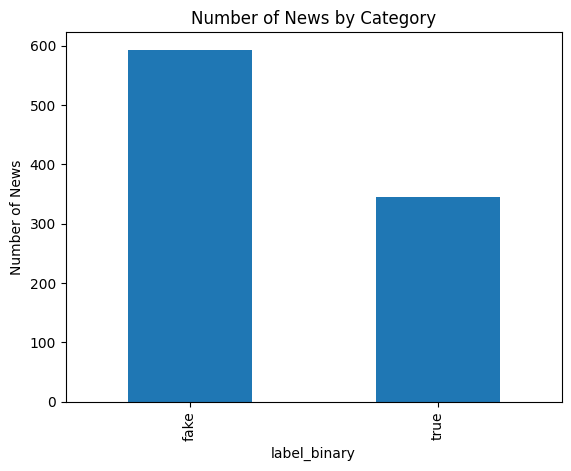

In [ ]:
# สรุปข้อมูลเบื้องต้นของจำนวนข่าวในแต่ละคลาส
num_true = (df['label_binary'] == 'true').sum()
num_fake = (df['label_binary'] == 'fake').sum()

print(f"Dataset Size: {len(df)} | ข่าวจริง: {num_true}, ข่าวปลอม: {num_fake}")

# กราฟแท่งแสดงจำนวนข่าวในแต่ละคลาส
try:
    df['label_binary'].value_counts().plot(kind='bar')
    plt.title('Number of News by Category')
    plt.ylabel('Number of News')
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

#  Thai tokenization stats (not used in BERT input)
df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)



In [ ]:
# =========================
# รอปรับให้เป็น content

# ดูตัวอย่าง tokenized titles and content
print("\nSample of tokenized content:")
print(df[['content', 'content_tokens']].head(1))

# Print token len().mean() statistic
print("\nToken statistics:")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

#--- TRUE NEWS SAMPLES ---
print("\nSample of true news content:")
print(df[df['label_binary'] == 'true'][['content', 'label_binary']].head(2))


#--- FAKE NEWS SAMPLES ---
print("\nSample of fake news content:")
print(df[df['label_binary'] == 'fake'][['content', 'label_binary']].head(2))

Sample of tokenized titles:
                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   

                                        title_tokens  
0  [OR, ชวน, ร่วม, เป็น, เจ้าของกิจการ, ลงทุน, หุ...  

Sample of tokenized content:
                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   

                                      content_tokens  
0  [จาก, ที่, มี, การ, โฆษณา, ระบุ, เปิด, ให้, ลง...  

Token statistics:
Average tokens in titles: 11.80
Average tokens in content: 113.36

Sample of true news title:
                                              title label_binary
8  กยศ. เร่งคืนเงินให้ผู้กู้ยืมที่ถูกหักเงินซ้ำซ้อน         true
9       ผู้ป่วยโรคฝีดาษในประเทศไทยลดน้อยลงในปี 2568         true

Sample of fake news title:
                                               title label_binary
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...         fake
1  กระทรวงยุติธรรม เปิดเพจเฟ

In [ ]:
# -------------------------------------------
#  ฟังก์ชันสร้าง BERT Embedding WangchanBERT 
# -------------------------------------------
#Decorator
@torch.no_grad()
def get_bert_embeddings_batch(
    texts,
    tokenizer,
    model,
    device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
):
    """
    สร้าง BERT embeddings แบบ batch สำหรับลิสต์ของข้อความ (texts)
    คืนค่าเป็น numpy array รูป (N, hidden_size)
    """

    model.eval()  # ให้แน่ใจว่าอยู่ในโหมด eval

    all_embeddings = []

    # loop ทีละ batch
    for start_idx in range(0, len(texts), batch_size):
        batch_texts = texts[start_idx:start_idx + batch_size]

        # กัน NaN / non-string
        batch_texts = [
            "" if (isinstance(t, float) and np.isnan(t)) else str(t)
            for t in batch_texts
        ]

        # Tokenize ทั้ง batch
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,          # padding ตาม batch
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state   # (B, seq_len, hidden)

            if use_mean_pool:
                # mean pooling ตาม attention mask
                attn = inputs['attention_mask'].unsqueeze(-1)      # (B, seq_len, 1)
                summed = (last_hidden * attn).sum(dim=1)           # (B, hidden)
                denom = attn.sum(dim=1).clamp(min=1)               # (B, 1)
                emb = (summed / denom).cpu().numpy()               # (B, hidden)
            else:
                # ใช้ CLS token
                emb = last_hidden[:, 0, :].cpu().numpy()           # (B, hidden)

        all_embeddings.append(emb)

    # รวมทุก batch เข้าด้วยกัน
    return np.vstack(all_embeddings)   # (N, hidden_size)

tensor

In [ ]:
# เตรียมข้อความ
texts = df['content'].fillna("").astype(str).tolist()

print("\nCreating BERT Embeddings for Content (batch)...")
content_emb = get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
)

print("content_emb shape:", content_emb.shape)  # ควรได้ (N, 768) สำหรับ WangchanBERT base

# ถ้ามีแค่ content อย่างเดียว ไม่ต้อง hstack
x_np = normalize(content_emb, axis=1, norm='l2')
y_np = df['label'].map(label2id).values

print("x_np shape:", x_np.shape)
print("Example vector (first 10 dims):", x_np[0][:10])


Creating BERT Embeddings for Title and Content...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Combined embedding shape (x_np): (938, 1536)
       0         1         2         3         4         5         6     \
0  0.009440 -0.055937  0.010781  0.009715 -0.020595 -0.016658  0.038007   
1 -0.018866 -0.013389  0.029290  0.028072 -0.023694  0.024845 -0.002467   
2 -0.004297 -0.054674  0.006164  0.025670 -0.008726 -0.025533  0.022739   
3 -0.004038 -0.037407  0.017466  0.014555 -0.016643  0.004019  0.036810   
4  0.050563  0.012704 -0.000594  0.020924  0.015106  0.027066  0.027630   

       7         8         9     ...      1526      1527      1528      1529  \
0 -0.002626 -0.004493  0.001407  ... -0.011996  0.003064  0.017463  0.001360   
1 -0.008415  0.002117 -0.026758  ...  0.012361  0.004698  0.013069  0.012872   
2 -0.017483 -0.005550  0.017755  ...  0.000092 -0.000812  0.001738  0.010710   
3 -0.022862 -0.012967  0.014511  ...  0.004602  0.002643  0.001115  0.022412   
4  0.013650  0.021515  0.013401  ... -0.005073  0.000831  0.013191 -0.001225   

       1530      1531  

หน้าตาเป็นไง ใช้สูตรอะไร

In [ ]:
# ดูตัวอย่าง DataFrame ของ Embedding
pd.DataFrame(x_np).head()

print(x_np.shape)   # ดูขนาด เช่น (จำนวนเอกสาร, ขนาดเวกเตอร์)
print(x_np[0])      # ดู embedding ของตัวอย่างแรก


(938, 1536)
[ 0.00943962 -0.05593715  0.01078102 ... -0.00691378  0.03518404
  0.01866273]


เสร็จ embedding //ทำไมจุดเป็นแบบนี้

In [ ]:

# แปลง labels -> ตัวเลข
classes = sorted(df['label'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['label'].map(label2id).values
print(f"Classes: {label2id}")

Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


In [ ]:
# ====================================================================
# kNN Graph Construction
# ====================================================================
k=8
N = x_np.shape[0]
print(f"\n--- Building kNN Graph with k={k} ---")

# 1. Fit kNN (เก็บ nbrs ไว้ใช้ใน predict_news)
nbrs = NearestNeighbors(n_neighbors=k + 1, metric='cosine').fit(x_np) 
dist, idx = nbrs.kneighbors(x_np) 

# 2. Create edges and weights (directed)
src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1) 

# 3. Make undirected
edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# 4. Coalesce
try:
    edge_index, edge_weight = coalesce(edge_index, edge_weight, N, reduce='mean')
except Exception as e: 
    print(f"Warning: coalesce failed ({e}), proceeding without coalesce.")


--- Building kNN Graph with k=8 ---


In [ ]:
#train_test_split
# ====================================================================
#  Create PyG Data and Train/Val/Test splits
# ====================================================================
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y, edge_weight=edge_weight).to(device)

# 70/15/15 split
idx_all = np.arange(N)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_np, random_state=42)
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_np[idx_train], random_state=42)

train_mask = torch.zeros(N, dtype=torch.bool, device=device); train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool, device=device); val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool, device=device); test_mask[idx_test] = True
data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

print(f"Train size: {train_mask.sum().item()}, Val size: {val_mask.sum().item()}, Test size: {test_mask.sum().item()}")

Train size: 656, Val size: 141, Test size: 141


In [ ]:
# # ตรวจสอบ label distribution
# print(y_np)  # แสดงค่าทุกอัน
# print(np.unique(y_np, return_counts=True))  

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 

In [ ]:
# ====================================================================
# GCN Model Definition and Evaluation Function
# ====================================================================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, getattr(data, 'edge_weight', None)
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x # logits

def evaluate_masked(logits, mask, data):
    y_true = data.y[mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, f1m

In [ ]:
# ====================================================================
# Training Setup and Loop
# ====================================================================
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(label2id)
LR_RATE = 1e-3
WEIGHT_DECAY = 5e-4
PATIENCE_LIMIT = 30
SCHEDULER_PATIENCE = 15
num_epochs = 500

model_gnn = GCNNet(num_node_features=NUM_NODE_FEATURES, num_classes=NUM_CLASSES).to(device)

# Class weights from train set
cls_count = np.bincount(y_np[idx_train], minlength=NUM_CLASSES).astype(np.float32)
cls_w = torch.tensor((cls_count.sum() / (cls_count + 1e-9)), dtype=torch.float, device=device)
cls_w = cls_w / cls_w.mean()

opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE)

best_val_f1, best_state, best_epoch = -1.0, None, 0
patience_counter = 0

print("\n--- Starting GCN Training ---")
for epoch in range(1, num_epochs + 1):
    model_gnn.train()
    opt.zero_grad()
    out = model_gnn(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    loss.backward()
    opt.step()

    model_gnn.eval()
    with torch.no_grad():
        val_acc, val_f1 = evaluate_masked(out, data.val_mask, data)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model_gnn.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    scheduler.step(val_f1)

    if epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val F1: {val_f1:.4f} | LR: {opt.param_groups[0]['lr']:.1e} | Patience: {patience_counter}")

    if patience_counter >= PATIENCE_LIMIT:
        print(f"\nEarly stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} (epoch {best_epoch})")
        break


--- Starting GCN Training ---

Early stopping at epoch 35. Best F1: 0.7020 (epoch 5)


In [ ]:
# load best state if available
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device) for k, v in best_state.items()})
else:
    print("Warning: best_state is None, using final model.")

In [ ]:
# ====================================================================
# Inductive Prediction Function (Final, clean version)
# ====================================================================
def predict_news(title=None, content=None, topn=None, x_np=None, label2id=None, device=None, nbrs=None, model_gnn=None):
    """
    Inductive prediction function for a single news item using GCN and BERT embeddings.
    Requires pre-fitted nbrs and trained GCN model.
    """
    assert title or content, "ต้องใส่อย่างน้อย title หรือ content"
    if topn is None: global k; topn = k
        
    if x_np is None or label2id is None or device is None or nbrs is None or model_gnn is None:
        raise ValueError("x_np, label2id, device, nbrs, and model_gnn must be provided as arguments.")
    
    # 1. Get BERT Embeddings
    title_emb = get_bert_embedding_from_text(title if title else "", use_mean_pool=True)
    content_emb = get_bert_embedding_from_text(content if content else "", use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2. Find k nearest neighbors and create feature matrix
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]])

    # 3. Build star mini-graph (new node 0 connected to neighbors 1..topn)
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1, topn + 1)]),
        np.stack([np.arange(1, topn + 1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # 4. Prepare PyG Data
    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)

    # 5. Run GCN Model
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(logits[0].argmax(dim=-1).item())
        label_pred = id2label[pred_id]

    return {'label': label_pred, 'probability': float(probas[pred_id]), 'proba_all': probas, 'id2label': id2label}

In [ ]:
# ====================================================================
# Evaluate GCN on Test set & Demo
# ====================================================================
model_gnn.eval()
with torch.no_grad():
    final_out_gcn = model_gnn(data)
    test_acc_gcn, test_f1_gcn = evaluate_masked(final_out_gcn, data.test_mask, data)
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()
    f1_class_gcn = f1_score(y_true_gcn, y_pred_gcn, average=None, zero_division=0)

results_gcn = {
    'Accuracy': test_acc_gcn,
    'F1-Macro': test_f1_gcn,
    'F1 (ข่าวจริง)': f1_class_gcn[label2id['ข่าวจริง']] if len(f1_class_gcn) > 0 else 0,
    'F1 (ข่าวปลอม)': f1_class_gcn[label2id['ข่าวปลอม']] if len(f1_class_gcn) > 1 else 0
}
print("-" * 50)
print(f"Test (GCN): Accuracy: {test_acc_gcn:.4f}, F1-Macro: {test_f1_gcn:.4f}")
print("Per-class F1 (GCN):", results_gcn)

# --- DEMO ---
print("\n--- DEMO: Test Inductive Prediction ---")
title_fake = "ด่วน! รัฐบาลออกกฎหมายบังคับให้ประชาชนทุกคนต้องฉีดวัคซีนป้องกันหวัดสายพันธุ์ใหม่"
content_fake = "ข่าวลือที่แพร่หลายในโซเชียลมีเดียระบุว่า หากไม่ฉีดวัคซีนตามที่รัฐบาลกำหนด จะถูกปรับเป็นเงิน 100,000 บาท"

try:
    result_fake = predict_news(title=title_fake, content=content_fake, x_np=x_np, label2id=label2id, device=device, nbrs=nbrs, model_gnn=model_gnn)
    print(f"\n[ข่าวปลอมตัวอย่าง]\nทำนาย: {result_fake['label']} | ความมั่นใจ: {result_fake['probability']:.3f}")
except Exception as e:
    print(f"\nPrediction demo failed: {e}")

--------------------------------------------------
Test (GCN): Accuracy: 0.5887, F1-Macro: 0.5870
Per-class F1 (GCN): {'Accuracy': 0.5886524822695035, 'F1-Macro': 0.5869696969696969, 'F1 (ข่าวจริง)': np.float64(0.5606060606060606), 'F1 (ข่าวปลอม)': np.float64(0.6133333333333333)}

--- DEMO: Test Inductive Prediction ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[ข่าวปลอมตัวอย่าง]
ทำนาย: ข่าวจริง | ความมั่นใจ: 0.691


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# 📌 1. กำหนดค่า 'k' (topn) หากยังไม่ได้กำหนดไว้เป็น Global Variable
# ค่านี้คือจำนวนเพื่อนบ้านที่ใช้สร้าง mini-graph
try:
    k 
except NameError:
    k = 8 
    print(f"Set default k = {k} for topn.")

# 📌 2. สร้างชุดข้อมูลทดสอบใหม่ (Test Set) 20 ข่าว
# 'label_true': 0 = ข่าวจริง, 1 = ข่าวปลอม (ตาม label2id: {'ข่าวจริง': 0, 'ข่าวปลอม': 1})
test_news_data = [
    # --- ข่าวจริง 10 ตัวอย่าง (Label 0) ---
    {"title": "ททท. เปิดตัว “ลิซ่า” เป็นตัวแทนการท่องเที่ยวไทย Amazing Thailand Ambassador", "content": "การท่องเที่ยวแห่งประเทศไทย (ททท.) ยืนยันการแต่งตั้ง 'ลิซ่า Blackpink' เป็นทูตการท่องเที่ยวเพื่อดึงดูดนักท่องเที่ยวต่างชาติ", "label_true": 0},
    {"title": "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก", "content": "กรมศิลปากรและหน่วยงานท้องถิ่นเข้าตรวจสอบและเริ่มกระบวนการซ่อมแซมองค์พระธาตุที่ได้รับความเสียหายจากพายุฝน", "label_true": 0},
    {"title": "บขส. เปิดให้บริการเดินรถโดยสาร เส้นทาง ขอนแก่น – นครหลวงเวียงจันทน์", "content": "บริษัท ขนส่ง จำกัด (บขส.) ประกาศกลับมาเปิดเดินรถระหว่างประเทศสายขอนแก่น-เวียงจันทน์แล้ว", "label_true": 0},
    {"title": "อุทยานฯ เขาพนมเบญจา ชวนนักท่องเที่ยว ตามรอยจูราสสิค เวิลด์ กำเนิดชีวิตใหม่ น้ำตกห้วยโต้", "content": "อุทยานแห่งชาติเขาพนมเบญจา จ.กระบี่ เปิดเส้นทางศึกษาธรรมชาติใหม่และเชิญชวนท่องเที่ยวในช่วงฤดูหนาว", "label_true": 0},
    {"title": "พบอิฐโบราณชิ้นสำคัญ หลักฐานทางประวัติศาสตร์ที่เก่าแก่ของเชียงราย", "content": "กรมศิลปากรยืนยันการค้นพบชิ้นส่วนอิฐสมัยโบราณในพื้นที่ อ.เชียงแสน ซึ่งเป็นหลักฐานสำคัญของอาณาจักรล้านนา", "label_true": 0},
    {"title": "ปิดเทอม สวนสัตว์เปิดเขาเขียว เผยโฉม 'ลูกสมเสร็จตัวล่าสุด' เด็กเที่ยวฟรี 23 ตุลาคมนี้", "content": "สวนสัตว์เปิดเขาเขียวเชิญชวนนักท่องเที่ยวชมลูกสมเสร็จเกิดใหม่ และมีโปรโมชั่นเข้าชมฟรีสำหรับเด็กในวันปิยมหาราช", "label_true": 0},
    {"title": "อาการเจ็บหน้าอก สัญญาณอันตรายที่ไม่ควรมองข้าม", "content": "สถาบันโรคหัวใจแนะนำให้ประชาชนรีบพบแพทย์ทันทีหากมีอาการเจ็บแน่นหน้าอกที่อาจเป็นสัญญาณของกล้ามเนื้อหัวใจขาดเลือด", "label_true": 0},
    {"title": "กกล.บูรพา จับกุมแรงงานกัมพูชา 11 คน ลักลอบข้ามชายแดนสระแก้ว", "content": "กองกำลังบูรพาแถลงการณ์จับกุมแรงงานต่างด้าวผิดกฎหมายตามแนวชายแดนได้จำนวนหนึ่งเพื่อป้องกันการแพร่ระบาด", "label_true": 0},
    {"title": "ททท.คาด 'เทศกาลกินผักภูเก็ต 2568' คึกคัก รายได้ทะลุ 22,000 ล้านบาท หนุนเศรษฐกิจสะพัด", "content": "การท่องเที่ยวแห่งประเทศไทยคาดการณ์ว่าเทศกาลกินเจที่ภูเก็ตในปีนี้จะมีมูลค่าทางเศรษฐกิจสูงกว่าปีที่ผ่านมา", "label_true": 0},
    {"title": "“ข้าวต้ม” ฟื้นตัวดี ถีบตัวลุกได้ ทีมแพทย์ช่วยกายภาพต่อเนื่อง", "content": "รายงานอาการล่าสุดของลูกช้างป่า 'ข้าวต้ม' พบว่าอาการบาดเจ็บดีขึ้นมาก สามารถพยุงตัวลุกยืนได้แล้ว และยังคงทำกายภาพบำบัด", "label_true": 0},
    
    # --- ข่าวปลอม 10 ตัวอย่าง (Label 1) ---
    {"title": "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย", "content": "มีรายงานข่าวลือทางโซเชียลมีเดียว่าสะพานกรุงเทพได้ถล่มลงมาเมื่อช่วงเช้าที่ผ่านมา ทำให้มีผู้บาดเจ็บและเสียชีวิตจำนวนมาก ซึ่งหน่วยงานรัฐยืนยันว่าเป็นข่าวปลอม", "label_true": 1},
    {"title": "กระทรวงยุติธรรม ร่วมกับ ตำรวจไซเบอร์ เปิดให้ลงทะเบียนยื่นหลักฐาน เพื่อรับเงินคืนจากมิจฉาชีพ", "content": "เพจเฟซบุ๊กปลอมเปิดรับลงทะเบียนเพื่อขอเงินคืนจากแก๊งคอลเซ็นเตอร์ โดยเรียกเก็บค่าธรรมเนียมก่อน ซึ่งถูกยืนยันแล้วว่าเป็นกลโกง", "label_true": 1},
    {"title": "การดื่มน้ำมะนาวสามารถทำลายมะเร็งเนื้อร้ายที่รุนแรงได้", "content": "ข่าวสุขภาพที่อ้างว่าน้ำมะนาวมีคุณสมบัติในการรักษาโรคมะเร็งได้ดีกว่าเคมีบำบัดนั้นถูกยืนยันโดยสถาบันมะเร็งแห่งชาติว่าเป็นข้อมูลเท็จ", "label_true": 1},
    {"title": "ผู้สูงอายุ 60 ปีขึ้นไป รับเงินอุดหนุนพิเศษ 3,000 บาท ไม่ต้องลงทะเบียน", "content": "ข้อความที่แชร์ในไลน์ว่าผู้สูงอายุจะได้รับเงินพิเศษ 3,000 บาทโดยอัตโนมัตินั้นไม่เป็นความจริง และไม่มีโครงการดังกล่าว", "label_true": 1},
    {"title": "กรมการขนส่งเปิดทำใบขับขี่ออนไลน์ ผ่านเพจเฟซบุ๊ก Pages DTL Noline", "content": "เพจเฟซบุ๊กแอบอ้างชื่อกรมการขนส่งทางบกเพื่อหลอกรับทำใบขับขี่ออนไลน์ โดยมีการเรียกเก็บค่าใช้จ่ายในการดำเนินการ", "label_true": 1},
    {"title": "กินถั่วลิสงวันละ 1 กำมือ ช่วยรักษาอาการวัยทอง อารมณ์แปรปรวน", "content": "ข้อมูลสุขภาพที่อ้างถึงการรักษาอาการวัยทองด้วยถั่วลิสงเป็นข่าวที่ไม่มีหลักฐานทางวิทยาศาสตร์รองรับและถูกจัดเป็นข่าวปลอม", "label_true": 1},
    {"title": "กฟภ. เปิดช่องทางติดต่อด่วน ทางไลน์ไอดี 'pea9394'", "content": "มีการแอบอ้างเป็นเจ้าหน้าที่การไฟฟ้าส่วนภูมิภาค (กฟภ.) ผ่านไลน์ไอดีที่ไม่เป็นทางการเพื่อหลอกลวงเก็บค่าไฟฟ้า", "label_true": 1},
    {"title": "สินเชื่อด่วนออมสิน สมัครง่าย ไม่ต้องใช้เอกสาร ติดต่อได้ที่เพจ Ulises Elizabeth Love", "content": "ธนาคารออมสินยืนยันว่าไม่มีนโยบายให้สินเชื่อผ่านเพจเฟซบุ๊กที่ไม่เป็นทางการ และเตือนภัยมิจฉาชีพที่แอบอ้าง", "label_true": 1},
    {"title": "รองแม่ทัพภาคที่ 2 ถูกตำหนิ เหตุรับเงินบริจาควัด", "content": "ข่าวที่ถูกนำเสนอว่ารองแม่ทัพถูกตำหนิเรื่องการรับเงินบริจาควัดนั้น ถูกกองทัพภาคที่ 2 ชี้แจงแล้วว่าเป็นการบิดเบือนข้อมูล", "label_true": 1},
    {"title": "วางก้อนน้ำแข็งบนท้ายทอย ช่วยรักษาโรคทางเดินหายใจ โรคหลอดเลือดหัวใจ และอาการปวดเมื่อยตามร่างกาย", "content": "ข้อความสุขภาพทางเลือกที่แนะนำให้ใช้น้ำแข็งรักษาหลายโรค เป็นข้อมูลที่ไม่ถูกต้องทางการแพทย์", "label_true": 1}
]

# 📌 3. วนลูปและทดสอบ (Testing)
y_true = []
y_pred = []
print("-" * 50)
print(f"--- Running Prediction on {len(test_news_data)} New Samples (topn={k}) ---")
print("-" * 50)

# กำหนด id2label เพื่อใช้อ้างอิงผลลัพธ์ (สมมติว่า label2id มีการกำหนดไว้)
id2label = {i: c for c, i in label2id.items()} 

for i, news in enumerate(test_news_data):
    # เรียกใช้ฟังก์ชัน predict_news โดยส่งพารามิเตอร์ทั้งหมดที่ฟังก์ชันต้องการ
    result = predict_news(
        title=news['title'],
        content=news['content'],
        x_np=x_np,        
        label2id=label2id,  
        device=device,      
        topn=k,
        nbrs=nbrs,          
        model_gnn=model_gnn 
    )
    
    # ดึงค่าผลลัพธ์
    label_id_pred = [k for k, v in id2label.items() if v == result['label']][0]
    
    y_true.append(news['label_true'])
    y_pred.append(label_id_pred)
    
    # แสดงผลลัพธ์แต่ละข่าว
    status = "✅ CORRECT" if label_id_pred == news['label_true'] else "❌ MISTAKE"
    
    print(f"[{status}] True: {id2label[news['label_true']]} | Pred: {result['label']} (Prob: {result['probability']:.3f})")
    if i == 9:
        print("\n--- Start of Fake News Examples ---")

# 📌 4. แสดงผลสรุปโดยใช้ Classification Report
print("-" * 50)
print("\n📝 CLASSIFICATION REPORT (20 Samples)")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'], zero_division=0))

--------------------------------------------------
--- Running Prediction on 20 New Samples (topn=8) ---
--------------------------------------------------


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวจริง | Pred: ข่าวปลอม (Prob: 0.722)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.509)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.557)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.526)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.685)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวจริง | Pred: ข่าวปลอม (Prob: 0.531)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.509)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.593)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวจริง | Pred: ข่าวปลอม (Prob: 0.604)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวจริง | Pred: ข่าวจริง (Prob: 0.744)

--- Start of Fake News Examples ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.514)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.599)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวปลอม | Pred: ข่าวจริง (Prob: 0.742)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.535)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.738)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.563)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.736)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[✅ CORRECT] True: ข่าวปลอม | Pred: ข่าวปลอม (Prob: 0.768)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวปลอม | Pred: ข่าวจริง (Prob: 0.626)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[❌ MISTAKE] True: ข่าวปลอม | Pred: ข่าวจริง (Prob: 0.716)
--------------------------------------------------

📝 CLASSIFICATION REPORT (20 Samples)
--------------------------------------------------
                 precision    recall  f1-score   support

ข่าวจริง (ID 0)       0.70      0.70      0.70        10
ข่าวปลอม (ID 1)       0.70      0.70      0.70        10

       accuracy                           0.70        20
      macro avg       0.70      0.70      0.70        20
   weighted avg       0.70      0.70      0.70        20



In [ ]:
# --------------------------------------------------------
# รันโค้ดทดสอบ 20 ข่าว
# --------------------------------------------------------
from sklearn.metrics import classification_report, accuracy_score, f1_score


# ตรวจสอบว่ามี y_true และ y_pred จากการทดสอบหรือไม่
try:
    if not y_true or not y_pred:
        raise ValueError("y_true และ y_pred ยังไม่มีข้อมูล (กรุณารันโค้ดทดสอบ 20 ข่าวใหม่ก่อน)")
except NameError:
    print("❌ ERROR: ตัวแปร y_true หรือ y_pred ไม่ถูกนิยาม กรุณารันโค้ดส่วนทดสอบข่าว 20 ข่าวใหม่ก่อน")
    # สิ้นสุดการทำงาน
except ValueError as e:
    print(f"❌ ERROR: {e}")
    # สิ้นสุดการทำงาน
else:
    # 1. คำนวณ Metric หลัก
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # 2. สร้าง Classification Report
    report = classification_report(y_true, y_pred, 
                                   target_names=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'], 
                                   output_dict=True, zero_division=0)
    
    # 3. จัดรูปแบบตารางสรุปหลัก
    summary_data = {
        'Metric': ['Accuracy', 'F1-Macro Avg', 'ข่าวจริง F1-Score', 'ข่าวปลอม F1-Score'],
        'Score': [acc, f1_macro, report['ข่าวจริง (ID 0)']['f1-score'], report['ข่าวปลอม (ID 1)']['f1-score']]
    }
    df_summary = pd.DataFrame(summary_data).set_index('Metric')
    
    # 4. จัดรูปแบบตารางสรุปรายคลาส
    df_class = pd.DataFrame({
        'Precision': [report['ข่าวจริง (ID 0)']['precision'], report['ข่าวปลอม (ID 1)']['precision']],
        'Recall': [report['ข่าวจริง (ID 0)']['recall'], report['ข่าวปลอม (ID 1)']['recall']],
        'F1-Score': [report['ข่าวจริง (ID 0)']['f1-score'], report['ข่าวปลอม (ID 1)']['f1-score']],
        'Support': [report['ข่าวจริง (ID 0)']['support'], report['ข่าวปลอม (ID 1)']['support']]
    }, index=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'])
    
    # 5. แสดงผลลัพธ์
    print("-" * 60)
    print("📊 สรุปประสิทธิภาพโมเดล GCN บนชุดทดสอบ 20 ข่าวใหม่")
    print("-" * 60)
    
    print("\n1. ผลลัพธ์รวม (Overall Performance):")
    display(df_summary.style.format({'Score': "{:.4f}"}))
    
    print("\n2. รายงานประสิทธิภาพรายคลาส (Per-Class Metrics):")
    display(df_class.style.format("{:.4f}"))
    
    print("-" * 60)
    print(f"✅ ความแม่นยำรวม (Accuracy): {acc:.4f} (ทำนายถูก {int(acc * len(y_true))} จาก 20 ข่าว)")
    print("-" * 60)

------------------------------------------------------------
📊 สรุปประสิทธิภาพโมเดล GCN บนชุดทดสอบ 20 ข่าวใหม่
------------------------------------------------------------

1. ผลลัพธ์รวม (Overall Performance):


,Score
Metric,
Accuracy,0.7000
F1-Macro Avg,0.7000
ข่าวจริง F1-Score,0.7000
ข่าวปลอม F1-Score,0.7000



2. รายงานประสิทธิภาพรายคลาส (Per-Class Metrics):


,Precision,Recall,F1-Score,Support
ข่าวจริง (ID 0),0.7000,0.7000,0.7000,10.0000
ข่าวปลอม (ID 1),0.7000,0.7000,0.7000,10.0000


------------------------------------------------------------
✅ ความแม่นยำรวม (Accuracy): 0.7000 (ทำนายถูก 14 จาก 20 ข่าว)
------------------------------------------------------------


In [ ]:
print("\n--- ทดสอบการทำนายข่าวใหม่ด้วย GCN Model ---")
title = input("กรอกหัวข้อข่าว (ถ้าไม่มี ให้กด Enter):\n")
content = input("กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน):\n")

# เช็คว่า:
if not title and not content:
    print("กรุณาใส่ title หรือเนื้อหาข่าว อย่างน้อย 1 อย่าง")
else:
    # 1. ทำนายข่าวใหม่ (Interactive Prediction)
    result = predict_news(
        title=title, 
        content=content, 
        x_np=x_np,         
        label2id=label2id,   
        device=device,       
        topn=k,
        nbrs=nbrs,           
        model_gnn=model_gnn 
    )
    
    # 2. แสดงผลการทำนาย
    print("\nผลการตรวจสอบข่าว:")
    print(f">>> ข่าวนี้น่าจะเป็น :  {result['label']}  (ความมั่นใจ = {result['probability']:.3f})")
    print("รายละเอียด probability (แต่ละ class):", result['proba_all'])
    
    # 3. นำ Metrics จากชุดทดสอบ (Test Set) มาแสดงผล (ใช้ตัวแปร results_gcn ที่คำนวณไว้แล้ว)
    print("\n📊 สรุปประสิทธิภาพโมเดล GCN บนชุดข้อมูลทดสอบ (Test Set)")
    print("-" * 45)
    print(f"{'Metric':<20} | {'Score':<10}")
    print("-" * 45)
    
    # ดึงค่า Metrics จาก results_gcn ที่คำนวณไว้ในโค้ดส่วนแรก
    print(f"{'Accuracy':<20} | {results_gcn['Accuracy']:.4f}")
    print(f"{'F1-Macro Avg':<20} | {results_gcn['F1-Macro']:.4f}")
    # print(f"{'F1 (ข่าวจริง)':<20} | {results_gcn['F1 (ข่าวจริง)']:.4f}")
    # print(f"{'F1 (ข่าวปลอม)':<20} | {results_gcn['F1 (ข่าวปลอม)']:.4f}")
    print("-" * 45)


--- ทดสอบการทำนายข่าวใหม่ด้วย GCN Model ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



ผลการตรวจสอบข่าว:
>>> ข่าวนี้น่าจะเป็น :  ข่าวจริง  (ความมั่นใจ = 0.710)
รายละเอียด probability (แต่ละ class): [0.7099937  0.29000625]

📊 สรุปประสิทธิภาพโมเดล GCN บนชุดข้อมูลทดสอบ (Test Set)
---------------------------------------------
Metric               | Score     
---------------------------------------------
Accuracy             | 0.5887
F1-Macro Avg         | 0.5870
---------------------------------------------


: 

In [ ]:


# ข่าวตัวอย่าง
title_fake = "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย"
content_fake = "มีรายงานข่าวลือทางโซเชียลมีเดียว่าสะพานกรุงเทพได้ถล่มลงมาเมื่อช่วงเช้าที่ผ่านมา ทำให้มีผู้บาดเจ็บและเสียชีวิตจำนวนมาก ซึ่งหน่วยงานรัฐยืนยันว่าเป็นข่าวปลอม"
title_real = "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก"
content_real = "กรมศิลปากรและหน่วยงานท้องถิ่นเข้าตรวจสอบและเริ่มกระบวนการซ่อมแซมองค์พระธาตุที่ได้รับความเสียหายจากพายุฝน"






# # ----------------------------------------------------------------
# # 🔹 ส่วนที่ 1: การประเมินผล Metrics บนชุดข้อมูลทดสอบทั้งหมด (Test Set)
# # ----------------------------------------------------------------

# # 1. แสดงผลตาราง Metrics รวม (จาก Test Set ทั้งหมด)
# print("-" * 70)
# print("📊 ผลการประเมิน Metrics บนชุดข้อมูลทดสอบ (Test Set ทั้งหมด)")
# print(f"| {'Model':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} |")
# print("-" * 70)
# # ผลลัพธ์จาก BERT + MLP
# print(f"| {'BERT (MLP)':<12} | {metrics_mlp['Accuracy']:.4f} | {metrics_mlp['Precision']:.4f} | {metrics_mlp['Recall']:.4f} | {metrics_mlp['F1-Score']:.4f} |")
# # ผลลัพธ์จาก GCN + BERT
# print(f"| {'GCN + BERT':<12} | {metrics_gcn['Accuracy']:.4f} | {metrics_gcn['Precision']:.4f} | {metrics_gcn['Recall']:.4f} | {metrics_gcn['F1-Score']:.4f} |")
# print("-" * 70)

# # ----------------------------------------------------------------
# # 🔹 ส่วนที่ 2: การทำนายแบบ Interactive (ข่าวใหม่ 1 ข่าว) และเปรียบเทียบ
# # ----------------------------------------------------------------

# print("\n--- ทดสอบการทำนายข่าวใหม่ (Interactive Prediction) ---")
# title = input("กรอกหัวข้อข่าว (ถ้าไม่มี ให้กด Enter):\n")
# content = input("กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน):\n")

# if not title and not content:
#     print("กรุณาใส่ title หรือเนื้อหาข่าว อย่างน้อย 1 อย่าง")
# else:
#     # 1. ทำนายด้วย GCN + BERT
#     result_gcn = predict_news(
#         title=title, 
#         content=content, 
#         x_np=x_np,        
#         label2id=label2id,  
#         device=device,      
#         topn=k,
#         nbrs=nbrs,          
#         model_gnn=model_gnn 
#     )

#     # 2. ทำนายด้วย BERT + MLP
#     result_mlp = predict_news_bert_only(
#         title=title, 
#         content=content, 
#         model_mlp=model_mlp, 
#         device=device, 
#         label2id=label2id
#     )
    
#     # 3. แสดงผลเปรียบเทียบ
#     print("\n--- ผลการทำนายสำหรับข่าวที่คุณกรอก ---")
#     print("-" * 70)
#     print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence':<12} | {'Proba KhawJing (0)':<20} |")
#     print("-" * 70)
    
#     # GCN + BERT
#     proba_gcn_real = result_gcn['proba_all'][label2id['ข่าวจริง']]
#     print(f"| {'GCN + BERT':<12} | {result_gcn['label']:<10} | {result_gcn['probability']:.4f} | {proba_gcn_real:.4f} |")
    
#     # BERT (MLP)
#     proba_mlp_real = result_mlp['proba_all'][label2id['ข่าวจริง']]
#     print(f"| {'BERT (MLP)':<12} | {result_mlp['label']:<10} | {result_mlp['probability']:.4f} | {proba_mlp_real:.4f} |")
#     print("-" * 70)

----------------------------------------------------------------------
📊 ผลการประเมิน Metrics บนชุดข้อมูลทดสอบ (Test Set ทั้งหมด)
| Model        | Accuracy   | Precision  | Recall     | F1-Score   |
----------------------------------------------------------------------
| BERT (MLP)   | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
| GCN + BERT   | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
----------------------------------------------------------------------

--- ทดสอบการทำนายข่าวใหม่ (Interactive Prediction) ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- ผลการทำนายสำหรับข่าวที่คุณกรอก ---
----------------------------------------------------------------------
| Model        | Prediction | Confidence   | Proba KhawJing (0)   |
----------------------------------------------------------------------
| GCN + BERT   | ข่าวจริง   | 0.5093 | 0.5093 |
| BERT (MLP)   | ข่าวปลอม   | 0.9054 | 0.0946 |
----------------------------------------------------------------------


In [ ]:
#--- ตัวอย่างการสร้าง GCN โมเดลง่ายๆ ---
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


BERT MLP for compare

In [ ]:
# =========================
# BERT MLP Baseline
# =========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  # raw logits

In [ ]:
NUM_FEATURES = x_np.shape[1]
model_mlp = MLPClassifier(input_dim=NUM_FEATURES, hidden_dim=128, output_dim=NUM_CLASSES).to(device)

# prepare train/val/test for MLP using same splits
X_train, Y_train = x_np[idx_train], y_np[idx_train]
X_val, Y_val = x_np[idx_val], y_np[idx_val]
X_test, Y_test = x_np[idx_test], y_np[idx_test]

X_train_t = torch.tensor(X_train, dtype=torch.float, device=device)
Y_train_t = torch.tensor(Y_train, dtype=torch.long, device=device)
X_val_t = torch.tensor(X_val, dtype=torch.float, device=device)
Y_val_t = torch.tensor(Y_val, dtype=torch.long, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=device)
Y_test_t = torch.tensor(Y_test, dtype=torch.long, device=device)

# class weights from train only
cls_count_mlp = np.bincount(Y_train, minlength=NUM_CLASSES).astype(np.float32)
cls_w_mlp = (cls_count_mlp.sum() / (cls_count_mlp + 1e-9))
cls_w_mlp = cls_w_mlp / cls_w_mlp.mean()
cls_w_mlp = torch.tensor(cls_w_mlp, dtype=torch.float, device=device)

opt_mlp = torch.optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=5e-4)

print("\n--- Starting BERT Embedding Baseline Training (MLP) ---")
best_val_f1_mlp = -1.0
best_state_mlp = None
for epoch in range(1, 101):
    model_mlp.train()
    opt_mlp.zero_grad()
    out = model_mlp(X_train_t)
    loss = F.cross_entropy(out, Y_train_t, weight=cls_w_mlp)
    loss.backward()
    opt_mlp.step()

    model_mlp.eval()
    with torch.no_grad():
        val_logits = model_mlp(X_val_t)
        y_val_pred = val_logits.argmax(dim=1).cpu().numpy()
        f1_val = f1_score(Y_val, y_val_pred, average='macro', zero_division=0)

    if f1_val > best_val_f1_mlp:
        best_val_f1_mlp = f1_val
        best_state_mlp = {k: v.detach().cpu().clone() for k, v in model_mlp.state_dict().items()}

# load best mlp state
if best_state_mlp is not None:
    model_mlp.load_state_dict({k: v.to(device) for k, v in best_state_mlp.items()})


--- Starting BERT Embedding Baseline Training (MLP) ---


In [ ]:
# ----------------------------------------------------------------
# คำนวณและจัดเก็บ Metrics ของ MLP Baseline (Test Set)
# ----------------------------------------------------------------

def evaluate_simple(logits, y_true):
    y_pred = logits.argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    f1_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    return acc, f1m, f1_class

# evaluate on test
model_mlp.eval()
with torch.no_grad():
    out_test_mlp = model_mlp(X_test_t)
    y_pred_mlp = out_test_mlp.argmax(dim=1).cpu().numpy()
    test_acc_mlp = accuracy_score(Y_test, y_pred_mlp)
    test_f1_mlp = f1_score(Y_test, y_pred_mlp, average='macro', zero_division=0)
    f1_class_mlp = f1_score(Y_test, y_pred_mlp, average=None, zero_division=0)

results_mlp = {
    'Accuracy': test_acc_mlp,
    'F1-Macro': test_f1_mlp,
    'F1 (ข่าวจริง)': f1_class_mlp[label2id['ข่าวจริง']] if len(f1_class_mlp) > 0 else 0,
    'F1 (ข่าวปลอม)': f1_class_mlp[label2id['ข่าวปลอม']] if len(f1_class_mlp) > 1 else 0
}
print("\nBaseline MLP results:", results_mlp)
print(f"✅ MLP Baseline Test F1-Macro: {test_f1_mlp:.4f}")


Baseline MLP results: {'Accuracy': 0.8723404255319149, 'F1-Macro': 0.8667016806722689, 'F1 (ข่าวจริง)': np.float64(0.8392857142857143), 'F1 (ข่าวปลอม)': np.float64(0.8941176470588236)}
✅ MLP Baseline Test F1-Macro: 0.8667


In [ ]:
# ✅ ฟังก์ชันทำนายด้วย BERT + MLP จริง
def predict_news_bert_only(title, content, tokenizer=None, model_mlp=None, device='cpu', label2id=None):
    if label2id is None:
        label2id = {'ข่าวจริง': 0, 'ข่าวปลอม': 1}

    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained("monsoon-nlp/bert-base-thai")
    if 'bert_model' not in globals():
        global bert_model
        bert_model = AutoModel.from_pretrained("monsoon-nlp/bert-base-thai").to(device)
        bert_model.eval()

    # ✅ แยก encode title และ content คนละรอบ
    def get_cls(text):
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # [CLS] token

    title_emb = get_cls(title)
    content_emb = get_cls(content)

    # ✅ รวม embedding เป็น vector 1536
    cls_emb = torch.cat((title_emb, content_emb), dim=1)

    # ✅ ส่งเข้า MLP
    with torch.no_grad():
        logits = model_mlp(cls_emb)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_id = int(np.argmax(probs))

    id2label = {v: k for k, v in label2id.items()}
    label = id2label[pred_id]
    confidence = float(probs[pred_id])

    return {
        "label": label,
        "probability": confidence,
        "proba_all": probs.tolist()
    }



# ✅ ฟังก์ชันทำนายด้วย GCN จริง
def predict_news(title=None, content=None, topn=None, x_np=None, label2id=None, device=None, nbrs=None, model_gnn=None):
    """
    Inductive prediction function for a single news item using GCN and BERT embeddings.
    Requires pre-fitted nbrs and trained GCN model.
    """
    assert title or content, "ต้องใส่อย่างน้อย title หรือ content"
    if topn is None: global k; topn = k
        
    if x_np is None or label2id is None or device is None or nbrs is None or model_gnn is None:
        raise ValueError("x_np, label2id, device, nbrs, and model_gnn must be provided as arguments.")
    
    # 1. Get BERT Embeddings
    title_emb = get_bert_embedding_from_text(title if title else "", use_mean_pool=True)
    content_emb = get_bert_embedding_from_text(content if content else "", use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2. Find k nearest neighbors and create feature matrix
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]])

    # 3. Build star mini-graph (new node 0 connected to neighbors 1..topn)
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1, topn + 1)]),
        np.stack([np.arange(1, topn + 1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # 4. Prepare PyG Data
    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)

    # 5. Run GCN Model
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(logits[0].argmax(dim=-1).item())
        label_pred = id2label[pred_id]

    return {'label': label_pred, 'probability': float(probas[pred_id]), 'proba_all': probas, 'id2label': id2label}


# ✅ Helper สำหรับแสดงค่าในตาราง
def safe_print_value(result, key, is_probability=False, index=None):
    if result is None or key not in result:
        return "N/A"

    value = result[key]

    # ถ้าเป็น numpy array ให้ดึงค่าออกมา
    if isinstance(value, np.ndarray):
        if index is not None:
            value = value[index]
        elif value.size == 1:
            value = value.item()

    # ถ้าต้องแสดงเป็นความน่าจะเป็น
    if is_probability:
        return f"{float(value):.4f}"

    # ถ้าเป็น list แล้วต้องเลือก index
    if isinstance(value, list) and index is not None:
        return f"{float(value[index]):.4f}"

    return str(value)


# ✅ Label mapping
label2id = {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


# ข่าวตัวอย่าง
title_fake = "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย"
content_fake = "มีรายงานข่าวลือทางโซเชียลมีเดียว่าสะพานกรุงเทพได้ถล่มลงมาเมื่อช่วงเช้าที่ผ่านมา ทำให้มีผู้บาดเจ็บและเสียชีวิตจำนวนมาก ซึ่งหน่วยงานรัฐยืนยันว่าเป็นข่าวปลอม"
title_real = "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก"
content_real = "กรมศิลปากรและหน่วยงานท้องถิ่นเข้าตรวจสอบและเริ่มกระบวนการซ่อมแซมองค์พระธาตุที่ได้รับความเสียหายจากพายุฝน"

# 🔸 รันโมเดล GCN
result_fake = predict_news(
    title=title_fake,
    content=content_fake,
    x_np=x_np,
    label2id=label2id,
    device=device,
    nbrs=nbrs,
    model_gnn=model_gnn
)
result_real = predict_news(
    title=title_real,
    content=content_real,
    x_np=x_np,
    label2id=label2id,
    device=device,
    nbrs=nbrs,
    model_gnn=model_gnn
)

# 🔸 รันโมเดล BERT + MLP
result_fake_bert = predict_news_bert_only(title_fake, content_fake, model_mlp=model_mlp, device=device, label2id=label2id)
result_real_bert = predict_news_bert_only(title_real, content_real, model_mlp=model_mlp, device=device, label2id=label2id)

# ----------------------------------------------------------------
# 🧾 ตารางเปรียบเทียบ: ข่าวปลอม (Fake News)
# ----------------------------------------------------------------
print("-" * 70)
print("ข่าวปลอมตัวอย่าง (Fake News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawPlom (1)':<18} |")
print("-" * 70)

label_gcn_f = safe_print_value(result_fake, 'label')
prob_gcn_f = safe_print_value(result_fake, 'probability', is_probability=True)
proba_all_gcn_f = safe_print_value(result_fake, 'proba_all', index=label2id['ข่าวปลอม'])
print(f"| {'GCN + BERT':<12} | {label_gcn_f:<10} | {prob_gcn_f:<18} | {proba_all_gcn_f:<18} |")

label_bert_f = safe_print_value(result_fake_bert, 'label')
prob_bert_f = safe_print_value(result_fake_bert, 'probability', is_probability=True)
proba_all_bert_f = safe_print_value(result_fake_bert, 'proba_all', index=label2id['ข่าวปลอม'])
print(f"| {'BERT (MLP)':<12} | {label_bert_f:<10} | {prob_bert_f:<18} | {proba_all_bert_f:<18} |")
print("-" * 70)

# ----------------------------------------------------------------
# 🧾 ตารางเปรียบเทียบ: ข่าวจริง (True News)
# ----------------------------------------------------------------
print("\nข่าวจริงตัวอย่าง (True News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawJing (0)':<18} |")
print("-" * 70)

label_gcn_r = safe_print_value(result_real, 'label')
prob_gcn_r = safe_print_value(result_real, 'probability', is_probability=True)
proba_all_gcn_r = safe_print_value(result_real, 'proba_all', index=label2id['ข่าวจริง'])
print(f"| {'GCN + BERT':<12} | {label_gcn_r:<10} | {prob_gcn_r:<18} | {proba_all_gcn_r:<18} |")

label_bert_r = safe_print_value(result_real_bert, 'label')
prob_bert_r = safe_print_value(result_real_bert, 'probability', is_probability=True)
proba_all_bert_r = safe_print_value(result_real_bert, 'proba_all', index=label2id['ข่าวจริง'])
print(f"| {'BERT (MLP)':<12} | {label_bert_r:<10} | {prob_bert_r:<18} | {proba_all_bert_r:<18} |")
print("-" * 70)

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


----------------------------------------------------------------------
ข่าวปลอมตัวอย่าง (Fake News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawPlom (1) |
----------------------------------------------------------------------
| GCN + BERT   | ข่าวปลอม   | 0.5142             | 0.5141596          |
| BERT (MLP)   | ข่าวปลอม   | 1.0000             | 1.0000             |
----------------------------------------------------------------------

ข่าวจริงตัวอย่าง (True News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawJing (0) |
----------------------------------------------------------------------
| GCN + BERT   | ข่าวจริง   | 0.5093             | 0.50933915         |
| BERT (MLP)   | ข่าวปลอม   | 0.9054             | 0.0946             |
----------------------------------------------------------------------


In [ ]:
inv_label_map = {v:k for k,v in label2id.items()}
print(inv_label_map)  # ต้องเป็น {0: 'ข่าวปลอม', 1: 'ข่าวจริง'}


{0: 'ข่าวจริง', 1: 'ข่าวปลอม'}


In [ ]:
print(final_out_gcn[test_mask])


tensor([[ 0.1153, -0.2367],
        [ 0.1996, -0.3030],
        [-0.3508,  0.3861],
        [ 0.1136, -0.2183],
        [-0.0105, -0.0455],
        [-0.0136, -0.0510],
        [ 0.2101, -0.3423],
        [-0.2935,  0.3082],
        [-0.0783,  0.0581],
        [-0.2927,  0.3012],
        [ 0.1768, -0.2694],
        [-0.3658,  0.3807],
        [ 0.1246, -0.2326],
        [-0.3381,  0.3543],
        [-0.1265,  0.1116],
        [ 0.1393, -0.2433],
        [-0.3154,  0.3316],
        [-0.0076, -0.0785],
        [ 0.0653, -0.1490],
        [-0.1834,  0.1878],
        [ 0.1108, -0.2024],
        [ 0.0648, -0.1281],
        [-0.3849,  0.3997],
        [ 0.0377, -0.1248],
        [ 0.1158, -0.2211],
        [-0.2710,  0.3032],
        [ 0.4811, -0.7073],
        [ 0.1181, -0.2054],
        [-0.2545,  0.2782],
        [ 0.0168, -0.0539],
        [ 0.1111, -0.2143],
        [-0.2847,  0.2756],
        [ 0.3178, -0.5043],
        [-0.2561,  0.2671],
        [ 0.2224, -0.3205],
        [-0.0482, -0

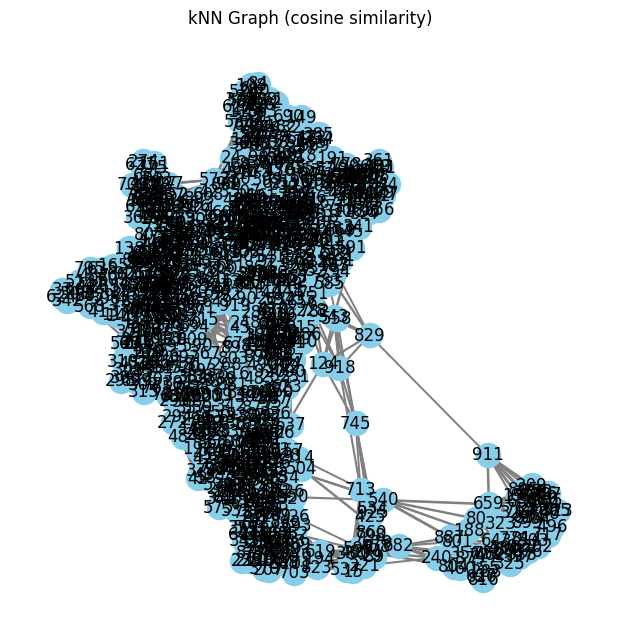

In [ ]:
# พล็อตกราฟ kNN
import networkx as nx
import matplotlib.pyplot as plt

# สร้างกราฟจาก edge_index_np
G = nx.Graph()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# ถ้าอยากใช้ weight เป็นความหนาของเส้น
weights = edge_weight_np

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout สวยงามอัตโนมัติ
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights * 2)
plt.title("kNN Graph (cosine similarity)")
plt.show()


node_pos: 30, color_map: 30, G.nodes: 30


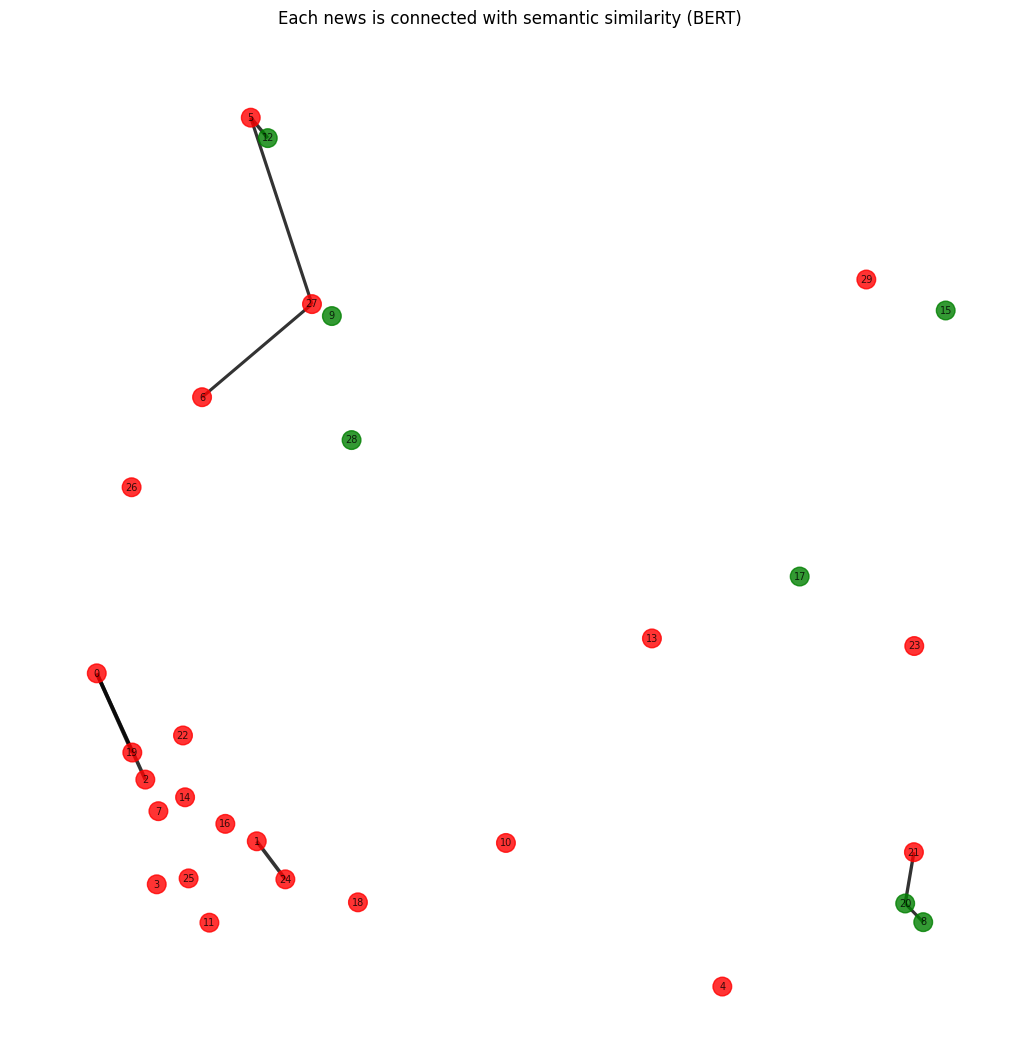

In [ ]:
#--- Visualize Subgraph ---
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# สมมติ plot 30 node แรก
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # เพื่อกัน node ที่ไม่มี edge หายไป
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='ข่าวปลอม' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

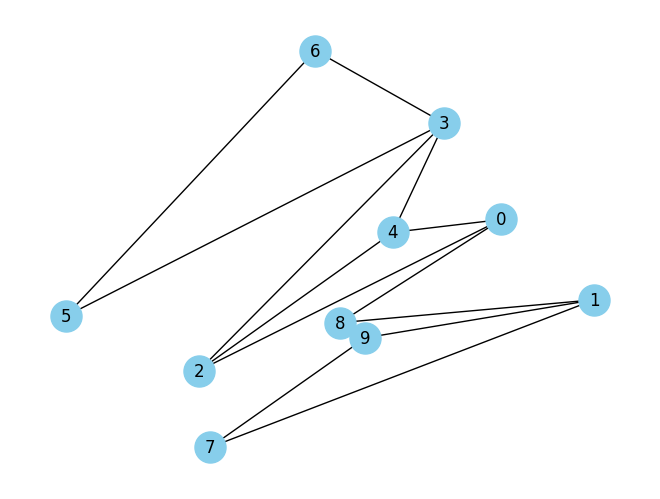

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN ง่ายๆ ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


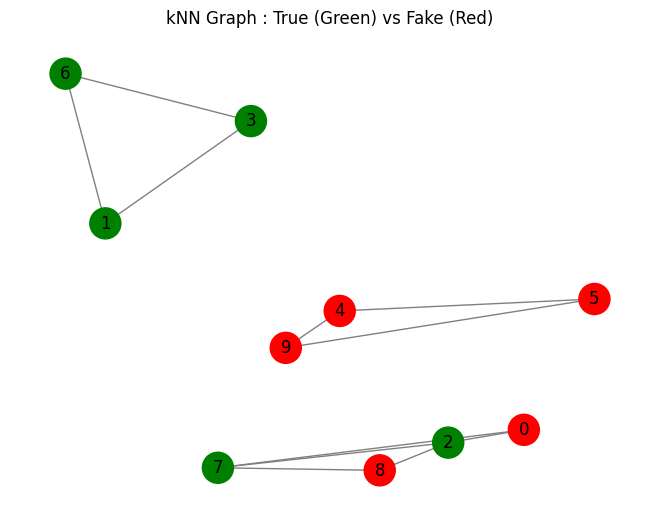

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN พร้อมสีโหนดจาก label ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


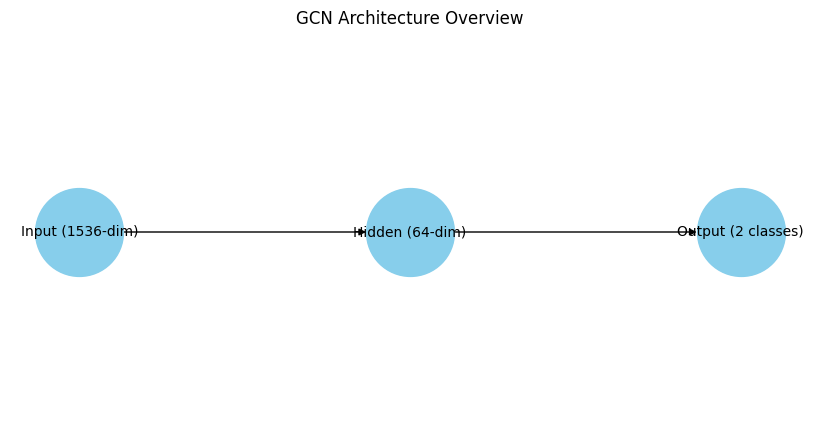

In [ ]:
# ----- วาดโครงสร้าง GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# เพิ่มโหนด
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# เพิ่ม edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# วาด
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


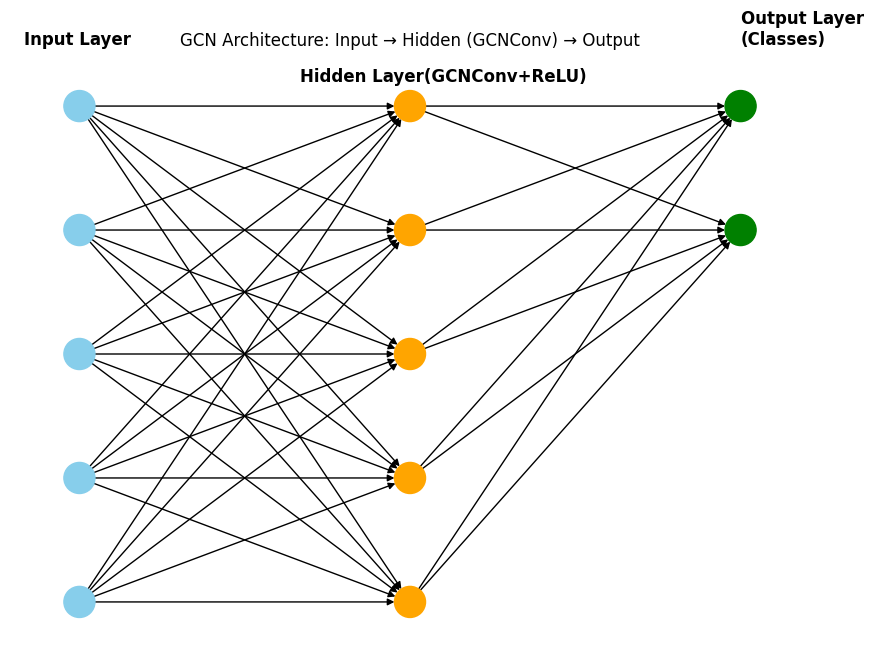

In [ ]:
#----- วาดโครงสร้าง GCN แบบละเอียด -----
import matplotlib.pyplot as plt
import networkx as nx

# สร้างโครงสร้าง GCN: Input Layer → Hidden Layer → Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ตัวอย่างมี 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# เพิ่ม node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# เชื่อม edge แบบ fully-connected ระหว่างแต่ละชั้น
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# จัดตำแหน่ง node แยกเป็น layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map สี
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# วาดกราฟ
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# เพิ่ม label ชื่อ layer (ใช้ตำแหน่งเฉพาะ)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input → Hidden (GCNConv) → Output")
plt.axis("off")
plt.show()




--- Visualization (t-SNE & PCA) ---
Using default SEED=42
Fitting t-SNE...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

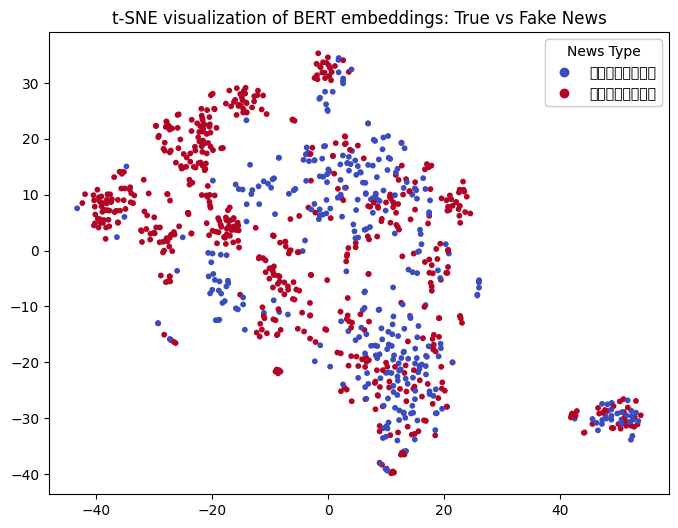

Fitting PCA...
PCA Explained Variance Ratio: Comp1=0.1628, Comp2=0.0595


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

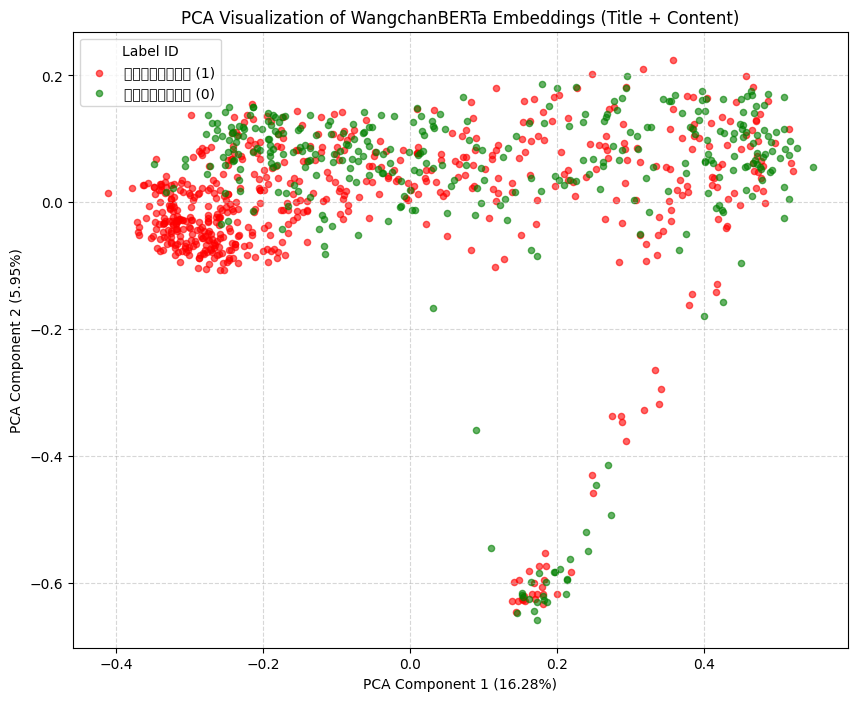

In [ ]:
# --------------------------------------------------------------------
# Visualization (t-SNE & PCA) 
# --------------------------------------------------------------------
print("\n--- Visualization (t-SNE & PCA) ---")

# กำหนด SEED 
try:
    SEED
except NameError:
    SEED = 42
    print(f"Using default SEED={SEED}")

try: 
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    print("Fitting t-SNE...")
    x_2d_tsne = tsne.fit_transform(x_np)
    
    plt.figure(figsize=(8, 6))
    # ใช้ y_np ที่เป็นตัวเลขแล้วในการระบายสี
    scatter = plt.scatter(x_2d_tsne[:, 0], x_2d_tsne[:, 1], c=y_np, cmap='coolwarm', s=10)
    plt.title("t-SNE visualization of BERT embeddings: True vs Fake News")
    
    # เพิ่ม คำอธิบายสี ใช้ชื่อ Label จาก label2id

    classes = list(label2id.keys())
    # สร้าง handle สำหรับ legend
    legend1 = plt.legend(
        handles=scatter.legend_elements()[0], 
        labels=classes, 
        title="News Type"
    )
    plt.gca().add_artist(legend1)

    plt.show()
except Exception as e: 
    print(f"t-SNE plot skipped: {e}")

try:
    # PCA
   
    pca = PCA(n_components=2, random_state=42)
    print("Fitting PCA...")
    x_2d_pca = pca.fit_transform(x_np)
    
    # ตรวจสอบให้แน่ใจว่า 'ข่าวปลอม' และ 'ข่าวจริง' มีใน label2id
    fake_id = label2id.get('ข่าวปลอม', -1)
    real_id = label2id.get('ข่าวจริง', -2)
    
    fake_mask = (y_np == fake_id)
    real_mask = (y_np == real_id)

    plt.figure(figsize=(10, 8))
    
    # พล็อตกราฟสำหรับข่าวปลอม
    if fake_id != -1:
        plt.scatter(x_2d_pca[fake_mask, 0], x_2d_pca[fake_mask, 1],
                    color='red', alpha=0.6, s=20, label=f'ข่าวปลอม ({fake_id})')
    
    # พล็อตกราฟสำหรับข่าวจริง
    if real_id != -2:
        plt.scatter(x_2d_pca[real_mask, 0], x_2d_pca[real_mask, 1],
                    color='green', alpha=0.6, s=20, label=f'ข่าวจริง ({real_id})')
                    
    plt.title("PCA Visualization of WangchanBERTa Embeddings (Title + Content)")
    plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    
    # แสดงค่า explained_variance_ratio
    print(f"PCA Explained Variance Ratio: Comp1={pca.explained_variance_ratio_[0]:.4f}, Comp2={pca.explained_variance_ratio_[1]:.4f}")

    plt.legend(title="Label ID")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print(f"PCA plot skipped: {e}")